In [1]:
# Install and load required libraries
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("harmony")

#install.packages("Seurat")
#install.packages("dplyr")
#install.packages("ggplot2")

# Load the libraries
library(Seurat)
library(harmony)
library(dplyr)
library(ggplot2)


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.23), R 4.3.2 (2023-10-31)

Installing package(s) 'harmony'




The downloaded binary packages are in
	/var/folders/3f/6pzn2nyn32d7wthyxkzsqyxcdrtvym/T//RtmptBpDEf/downloaded_packages


Old packages: 'aplot', 'datawizard', 'hardhat', 'performance',
  'spatstat.utils', 'uwot', 'codetools'

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Create a directory to store the data
dir.create("pbmc3k_data")
# Set the working directory
setwd("pbmc3k_data")
download.file("https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz", destfile = "pbmc3k_filtered_gene_bc_matrices.tar.gz")
# Extract the downloaded file
untar("pbmc3k_filtered_gene_bc_matrices.tar.gz")

# List the files to ensure the correct structure
list.files("filtered_gene_bc_matrices/hg19/")

Warning message in dir.create("pbmc3k_data"):
“'pbmc3k_data' already exists”


[1] "barcodes.tsv" "genes.tsv"    "matrix.mtx"

In [3]:
# Load the pbmc3k dataset
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  MALAT1, LTB, IL32, CD2, ACAP1, STK17A, CTSW, CD247, CCL5, GIMAP5 
	   AQP3, GZMA, CST7, TRAF3IP3, MAL, HOPX, ITM2A, GZMK, MYC, BEX2 
	   GIMAP7, ETS1, LDLRAP1, ZAP70, LYAR, RIC3, TNFAIP8, KLRG1, SAMD3, NKG7 
Negative:  CST3, TYROBP, LST1, AIF1, FTL, FCN1, LYZ, FTH1, S100A9, FCER1G 
	   TYMP, CFD, LGALS1, CTSS, S100A8, SERPINA1, LGALS2, SPI1, IFITM3, PSAP 
	   CFP, SAT1, IFI30, COTL1, S100A11, NPC2, LGALS3, GSTP1, PYCARD, NCF2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DRA, HLA-DQB1, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DPB1, HLA-DMA, HLA-DQA2, HLA-DRB5, HLA-DPA1, HLA-DMB, FCRLA, HVCN1, LTB, BLNK 
	   KIAA0125, P2RX5, IRF8, IGLL5, SWAP70, ARHGAP24, SMIM14, PPP1R14A, FCRL2, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB, FGFBP2, CTSW, GNLY, GZMH, SPON2 
	  

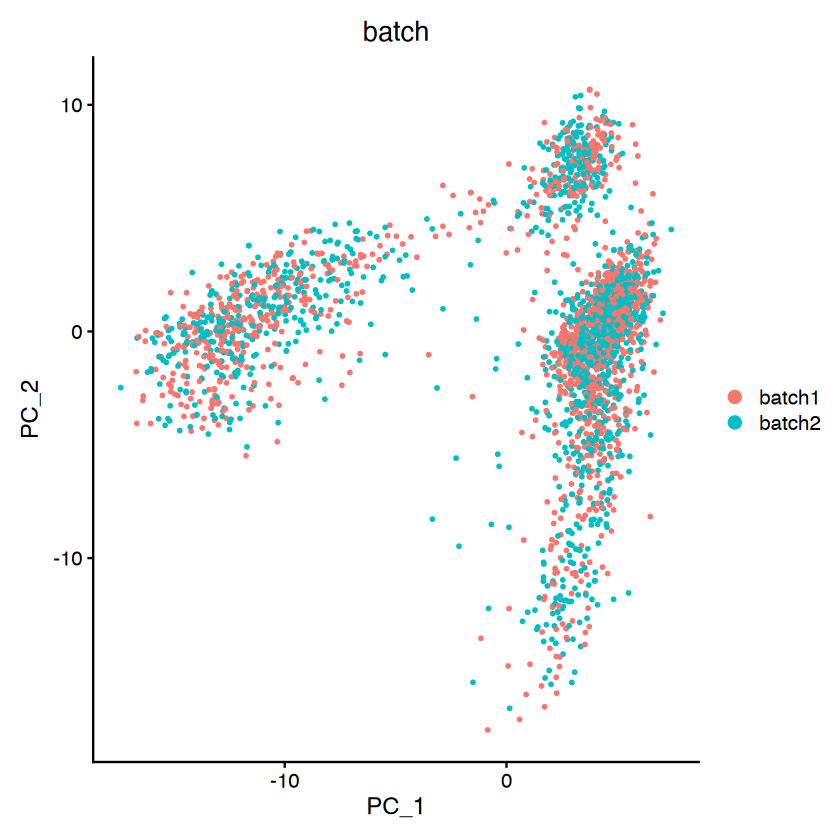

In [4]:
# Create a Seurat object
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

# Add metadata for batches if not already present
# For example, here we create a random batch assignment
set.seed(1234)
pbmc$batch <- sample(c("batch1", "batch2"), ncol(pbmc), replace = TRUE)

# Standard pre-processing
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
pbmc <- ScaleData(pbmc)
pbmc <- RunPCA(pbmc)

# Visualize the PCA results
DimPlot(pbmc, reduction = "pca", group.by = "batch")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:46:07 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

13:46:07 Read 2700 rows and found 20 numeric columns

13:46:07 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

13:46:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2700
Number of edges: 120239

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8635
Number of communities: 8
Elapsed time: 0 seconds


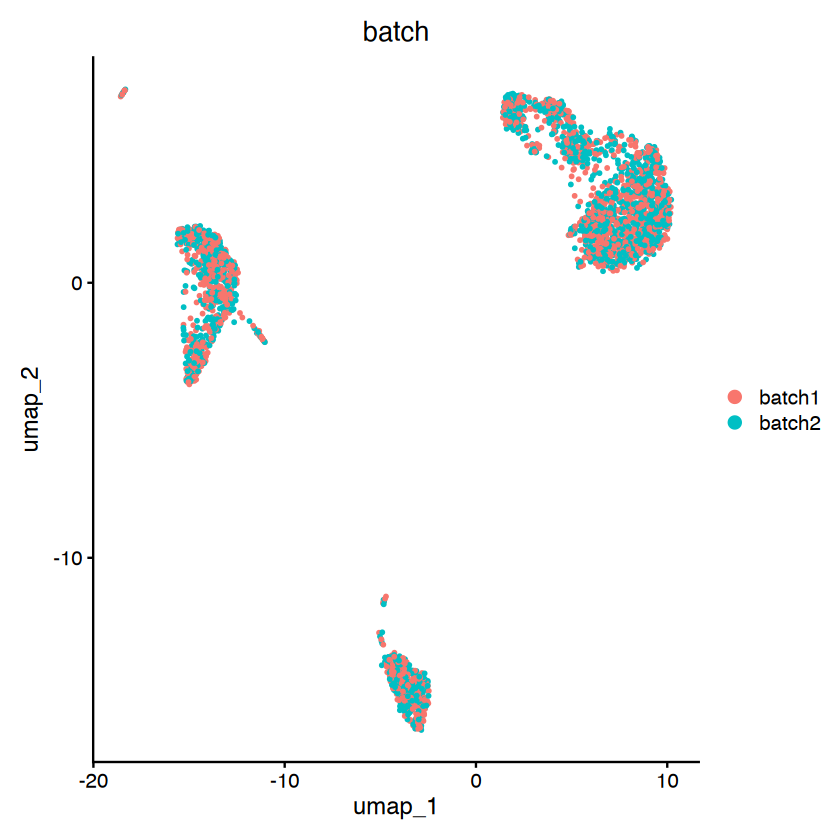

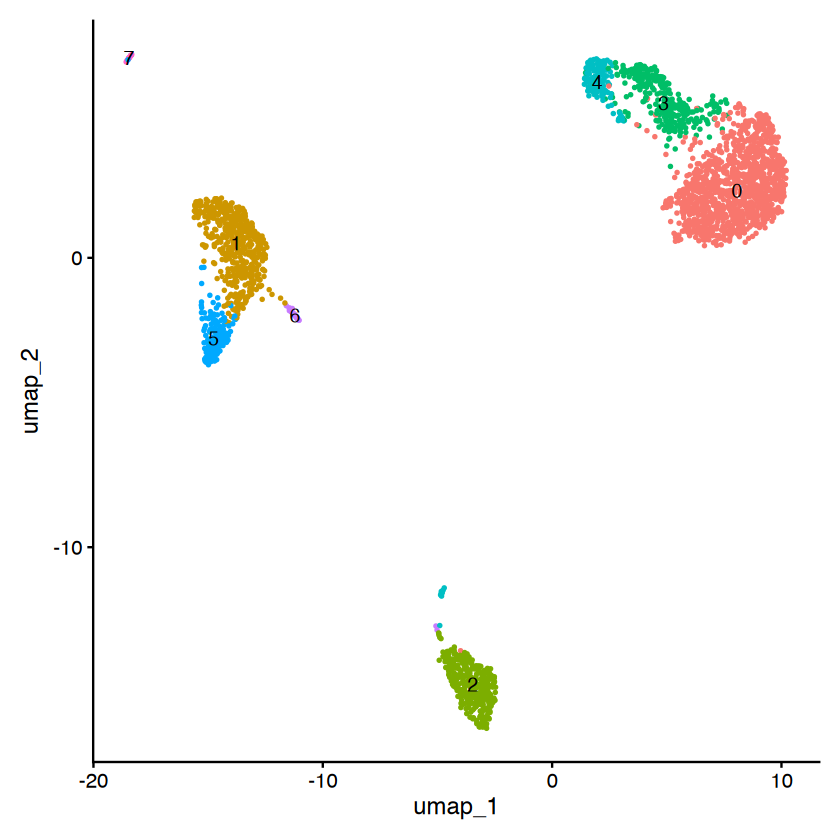

In [5]:
# Run Harmony
pbmc <- RunHarmony(pbmc, group.by.vars = "batch")

# Continue with downstream analysis using Harmony embeddings
pbmc <- RunUMAP(pbmc, reduction = "harmony", dims = 1:20)
pbmc <- FindNeighbors(pbmc, reduction = "harmony", dims = 1:20)
pbmc <- FindClusters(pbmc, resolution = 0.5)

# Visualize the results
DimPlot(pbmc, reduction = "umap", group.by = "batch")
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()
